# IPython and cross language integration

This is demo on how cross-language integration works in a Jupyter notebook by using the features of the Reference IPython Kernel implementation.
These features are only on the Kernel basis and need to be reimplemented on a per-kernel basis. 

Most of what you will see here are thin wrappers around already existing libraries, that do all the heavy lifinting, 
we just showing how seamless a cross languaguage environement can be. 

# Basic Python cross-language integration

Python offer many facilities to call into other languages, wether we "shell-out"

## Steamlining calling subprocess

Well IPython define what are called Magics  `%something` for line magics, act only on the rest of the line, and call magics (start with `%%`)

In [2]:
%%ruby --out fib15
def fibonacci( n )
  return  n  if ( 0..1 ).include? n
  ( fibonacci( n - 1 ) + fibonacci( n - 2 ) )
end
puts fibonacci( 15 )

In [5]:
int(fib15.strip())

610

Ok, that's somewhat usefull, but not really that much right ? You cannot pass variable in... or can't you ? 

### Send variables in 

Calling subprocess can be quite cumbersome when workign interactively

In [6]:
import random
import string

def rand_names(k=10,l=10):
    for i in range(k):
        yield '_' + ''.join(random.choice(string.ascii_letters) for i in range(l))+'.o'
    

In [7]:
for f in rand_names():
    !touch $f

In [8]:
ls

Cargo.lock                              _WJhXddnfZu.o
Cargo.toml                              _YcfFsWSaYU.o
Cross Language Integration.ipynb        _bkTNuJxZPs.o
_LRfqpTUMoU.o                           _cAmhciQbxr.o
_LXqIyyjUBW.o                           _cffi_oXYccNACnn.c
_QuDKoqWvRh.o                           _cffi_oXYccNACnn.cpython-35m-darwin.so*
_TWJdFcPOoX.o                           _cffi_oXYccNACnn.o
_UPplhgGGgn.o                           src/
_VbbrkzNhYQ.o                           target/


In [9]:
files = !ls *.o
files

['_LRfqpTUMoU.o',
 '_LXqIyyjUBW.o',
 '_QuDKoqWvRh.o',
 '_TWJdFcPOoX.o',
 '_UPplhgGGgn.o',
 '_VbbrkzNhYQ.o',
 '_WJhXddnfZu.o',
 '_YcfFsWSaYU.o',
 '_bkTNuJxZPs.o',
 '_cAmhciQbxr.o',
 '_cffi_oXYccNACnn.o']

In [10]:
!rm *.o

In [11]:
ls

Cargo.lock                              _cffi_oXYccNACnn.cpython-35m-darwin.so*
Cargo.toml                              src/
Cross Language Integration.ipynb        target/
_cffi_oXYccNACnn.c


Ok, that's pretty conveninent, it's kind-of inlineing bash-one liners where you can inject Python strin in it. 
what about multilines ? 

In [12]:
import rpy2.rinterface

In [13]:
import os

In [14]:
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
%load_ext rpy2.ipython
from rpy2.interactive import process_revents

In [15]:
def fib(n):
    if n<2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

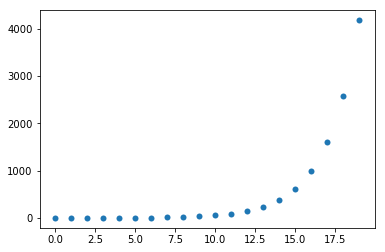

In [16]:
import numpy as np
X = np.arange(20)
Y = np.array([fib(x) for x in X])
import matplotlib.pyplot as plt
plt.scatter(X,Y)

In [17]:
%Rpush Y X

In [18]:
%%R
s = summary(lm(Y~X))
val <- s$coefficients

In [20]:
%R val

array([[ -6.85242857e+02,   3.38412077e+02,  -2.02487708e+00,
          5.79739741e-02],
       [  1.29741353e+02,   3.04517583e+01,   4.26055376e+00,
          4.70513265e-04]])

In [21]:
coefs = %Rget val
coefs

array([[ -6.85242857e+02,   3.38412077e+02,  -2.02487708e+00,
          5.79739741e-02],
       [  1.29741353e+02,   3.04517583e+01,   4.26055376e+00,
          4.70513265e-04]])

### What about redefinig functions ? 

# Mix and match languages: Julia

In [ ]:
%load_ext julia.magic

In [ ]:
%julia @pyimport matplotlib.pyplot as plt
%julia @pyimport numpy as np
%matplotlib inline

In [ ]:
%%julia
# Note how we mix numpy and julia:
t = linspace(0,2*pi,1000); # use the julia linspace
s = sin(3*t + 4*np.cos(2*t)); # use the numpy cosine and julia sine
fig = plt.gcf()  # **** WATCH THIS VARIABLE ****
plt.plot(t, s, color="red", linewidth=2.0, linestyle="--")

# Deep cross-language integration

In [ ]:
fig = %julia fig           # Python % Julia
fig.suptitle('A simple plot')    # Python
fig                              # Python  

# The stack as a layer cake

In [ ]:
from __future__ import print_function

jlfib = %julia _fib(n, pyfib) = n < 2 ? n : pyfib(n-1, _fib) + pyfib(n-2, _fib)
    
def pyfib(n, _fib):
    print('(P', end='')
    if n < 2:
         r = n
    else:
        print('(J', end='')
        r =  _fib(n-1, pyfib) + _fib(n-2, pyfib)
        print(')',end='')
    return r

fibonacci = lambda x: pyfib(x, jlfib)

fibonacci(10)

# CFFI

## Mix and Match : C

Expose some ability to inline C and rust through CFFI

In [22]:
import cffi_magic

In [23]:
rm *.o *.c *.so

rm: *.o: No such file or directory


In [24]:
ls

Cargo.lock                        src/
Cargo.toml                        target/
Cross Language Integration.ipynb


In [30]:
%%cffi int cfib(int);

int cfib(int n)
{ return _cfib(n);}

int _cfib(int);
int _cfib(int n)
{
    int res=0;
    if (n <= 2){
        res = 1;
    } else {
        res = _cfib(n-1)+_cfib(n-2);
    }
    return res;
}

In [31]:
cfib(4)

3

## Mix and Match : rust

In [43]:
%%rust int rfib(int);

#[no_mangle]
pub extern fn rfib(n: i32) -> i32 {
    match n {
        0 => 0,
        1 => 1,
        2 => 1,
        _ => rfib(n-1)+rfib(n-2)
    }
}

injecting  rfib in user ns


In [ ]:
def poly(j):
    return  j**2+3*j

def fun():
    i = 0 
    for j in range(2000000000000):
        i = i+poly(j)
    return i


In [33]:
([rfib(i) for i in range(10)],
[cfib(i) for i in range(10)])

([0, 1, 1, 2, 3, 5, 8, 13, 21, 34], [1, 1, 1, 2, 3, 5, 8, 13, 21, 34])

In [34]:
fib(rfib(cfib(6)))

10946

In [38]:
ls -al

total 384
drwxr-xr-x  17 bussonniermatthias  staff    578 Aug  3 17:10 ./
drwxr-xr-x  13 bussonniermatthias  staff    442 Aug  3 11:06 ../
drwxr-xr-x   3 bussonniermatthias  staff    102 Aug  3 09:11 .ipynb_checkpoints/
-rw-r--r--   1 bussonniermatthias  staff    254 Aug  3 17:09 Cargo.lock
-rw-r--r--   1 bussonniermatthias  staff    197 Aug  3 17:09 Cargo.toml
-rw-r--r--   1 bussonniermatthias  staff  27147 Aug  3 17:10 Cross Language Integration.ipynb
-rw-r--r--   1 bussonniermatthias  staff  17966 Aug  3 17:09 _cffi_AAOYppblFI.c
-rwxr-xr-x   1 bussonniermatthias  staff   9980 Aug  3 17:09 _cffi_AAOYppblFI.cpython-35m-darwin.so*
-rw-r--r--   1 bussonniermatthias  staff  19344 Aug  3 17:09 _cffi_AAOYppblFI.o
-rw-r--r--   1 bussonniermatthias  staff  17966 Aug  3 17:09 _cffi_lJXVAEAmUh.c
-rwxr-xr-x   1 bussonniermatthias  staff   9980 Aug  3 17:09 _cffi_lJXVAEAmUh.cpython-35m-darwin.so*
-rw-r--r--   1 bussonniermatthias  staff  19344 Aug  3 17:09 _cffi_lJXVAEAmUh.o
-rw-r--r--   1 busso

In [35]:
import itertools

In [36]:
list(itertools.permutations([fib,cfib,rfib]))

[(<function __main__.fib>,
  <function _cffi_lJXVAEAmUh.CompiledLib.cfib>,
  <cdata 'int(*)(int)' 0x120799b40>),
 (<function __main__.fib>,
  <cdata 'int(*)(int)' 0x120799b40>,
  <function _cffi_lJXVAEAmUh.CompiledLib.cfib>),
 (<function _cffi_lJXVAEAmUh.CompiledLib.cfib>,
  <function __main__.fib>,
  <cdata 'int(*)(int)' 0x120799b40>),
 (<function _cffi_lJXVAEAmUh.CompiledLib.cfib>,
  <cdata 'int(*)(int)' 0x120799b40>,
  <function __main__.fib>),
 (<cdata 'int(*)(int)' 0x120799b40>,
  <function __main__.fib>,
  <function _cffi_lJXVAEAmUh.CompiledLib.cfib>),
 (<cdata 'int(*)(int)' 0x120799b40>,
  <function _cffi_lJXVAEAmUh.CompiledLib.cfib>,
  <function __main__.fib>)]

In [37]:
from time import sleep
for x,y,z in itertools.permutations([fib,cfib,rfib]):
    print([type(_) for _ in [x,y,z]])
    print(x(y(z(6))))

[<class 'function'>, <class 'builtin_function_or_method'>, <class '_cffi_backend.CData'>]
10946
[<class 'function'>, <class '_cffi_backend.CData'>, <class 'builtin_function_or_method'>]
10946
[<class 'builtin_function_or_method'>, <class 'function'>, <class '_cffi_backend.CData'>]
10946
[<class 'builtin_function_or_method'>, <class '_cffi_backend.CData'>, <class 'function'>]
10946
[<class '_cffi_backend.CData'>, <class 'function'>, <class 'builtin_function_or_method'>]
10946
[<class '_cffi_backend.CData'>, <class 'builtin_function_or_method'>, <class 'function'>]
10946


### Mix and Match : Rust & C

In [ ]:
#sextuple = lambda x:triple(double(x))
#sextuple(3)

## All in one

In [ ]:
import sys
!#{sys.executable} -m pip install ipywidgets --upgrade

In [ ]:
def scan(value):
    return [1,3,3,5,5][:len(value)]


assert scan([]) == []
assert scan([1]) == [1]
assert scan([1,3]) == [1,3]
assert scan([1,3,1]) == [1,3,3]
assert scan([1,3,1,5,3]) == [1,3,3,5,5]

In [ ]:
from ipywidgets import interact

@interact(x=(5,10))
def allinone(x=4):
    return triple(fibonacci(x))


### TL:DR;

    (Visualisation Side) 
      Javascript 
        -> Python 
           -> C 
             -> rust 
               -> (Julia<->Python)*N
    (Data/Computation side)
    
Note that Python Side, can use SciPy that can rely on C (again) and on Fortran.
Not shown here, communication with R, Bash, ...
    

## If enough time ...

Turn this notebook into a presentation